In [ ]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

| | |
|----------|-------------|
| Author(s)   | Lei Pan |
| Last updated | 10/26/2023 |

# Create and Deploy a Live Website from a Wireframe with Codey and GCP Services

Codey models are text-to-code models from Google AI, trained on a massive code related dataset. You can generate code related responses for different scenarios such as writing functions, unit tests, debugging, explaining code etc. Here is [the overview](https://cloud.google.com/vertex-ai/docs/generative-ai/code/code-models-overview) of all the Codey APIs.

In this notebook, we will show you how to use Codey Chat API to generate functions, explain code, generate unit tests, and assist code refactoring and modification through a website development example.

We will create and deploy a live website from a wireframe by following the steps below.

- Step 1: Describe login page design via ImageText model
- Step 2: Use the description to generate HTML and CSS code
- Step 3: Deploy static website to GCP
- Step 4: Change website design (login button color)
- Step 5: Add javascript code to handle the login logic
- Step 6: Write unit test for javascript code
- Step 7: Explain generated HTML, CSS and javascript code
- Step 8: Refactor the code via Codey

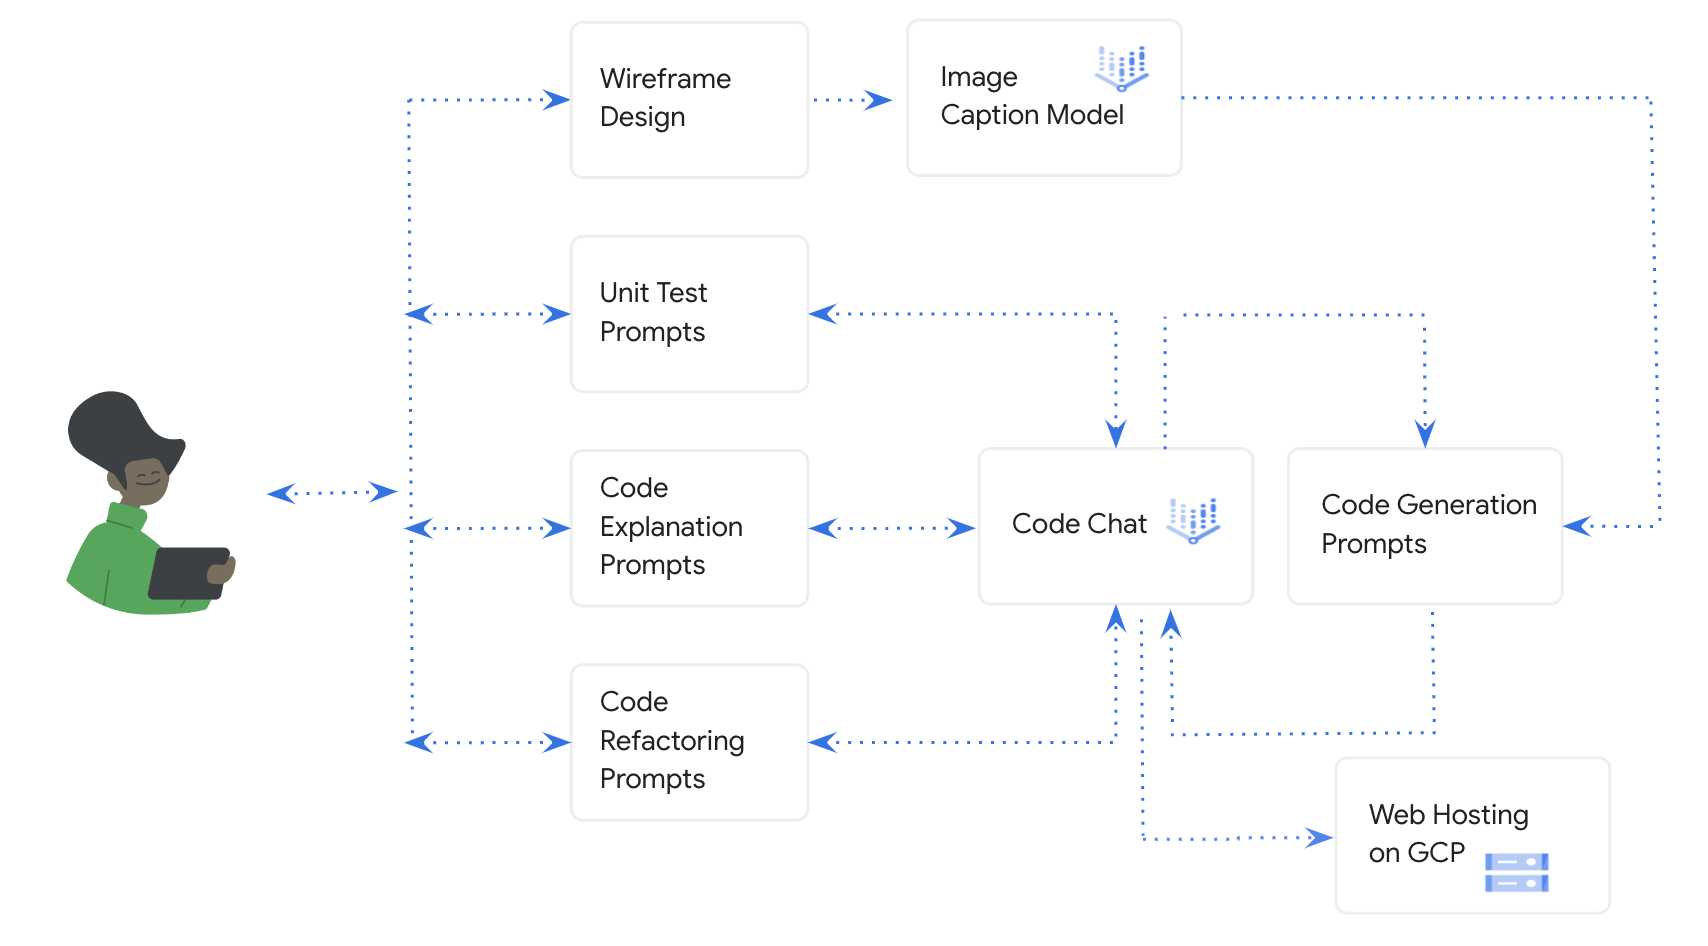

## Prep Work

If you don't have a GCP project set up and Vertex AI enabled, please follow [the doc](https://cloud.google.com/vertex-ai/docs/start/cloud-environment#set_up_a_project) to set them up before you proceed.



### Install Vertex AI SDK, Other Packages and Their Dependencies

Install the following packages required to execute this notebook.

In [ ]:
import sys

if 'google.colab' in sys.modules:
    ! pip install google-cloud-aiplatform
    from google.colab import auth as google_auth
    google_auth.authenticate_user()

Replace the values of the variables below according to your project specification.

In [ ]:
import vertexai
from vertexai.language_models import CodeGenerationModel

VERTEX_API_PROJECT = '<your project>'
VERTEX_API_LOCATION = '<location>'

vertexai.init(project=VERTEX_API_PROJECT, location=VERTEX_API_LOCATION)

## Step 1: Describe Login Page Design via ImageText model

Save below image as loginpage.png and upload it to colab files folder on the left side of current colab page.

In this way, you can retrieve this image and pass it to the image caption model in the cell below.

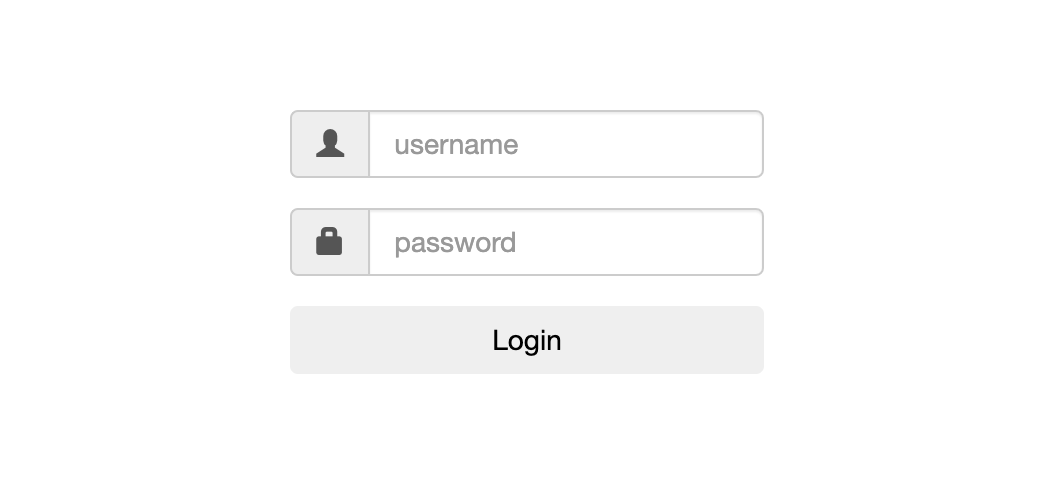

You can specify the version of the image models you want to use. Here is [the list](https://cloud.google.com/vertex-ai/docs/generative-ai/image/model-versioning)  of all the available models. Here is [an overview](https://cloud.google.com/vertex-ai/docs/generative-ai/image/visual-question-answering) of the ImageText models.

Call ImageText Model to generate description of the login page, you only need to pass 3 parameters

- source_image: the location of the image
- number_of_results: how many descriptions you want to generate
- language: which language want to use

In [ ]:
from vertexai.vision_models import ImageTextModel, Image
model = ImageTextModel.from_pretrained("imagetext@001")

source_image = Image.load_from_file(location='loginpage.png')

captions = model.get_captions(
    image=source_image,
    number_of_results=1,
    language="en",
)
print(captions)

['a login page for a website with username and password fields']


## Step 2: Use the Description to Generate HTML and CSS code

Call code chat API to generate HTML and CSS code from this description of the login page.

- You can specify the version of the Codey models you want to use. Here is [the list](https://cloud.google.com/vertex-ai/docs/generative-ai/learn/model-versioning)  of all the available models


- You can pass 3 parameters here: prompt, max size of token, and temperature.

In [ ]:
from vertexai.language_models import CodeChatModel

code_chat_model = CodeChatModel.from_pretrained("codechat-bison")
chat = code_chat_model.start_chat()

In [ ]:
def send_message(message, max_token=1024):
    parameters = {
    "temperature": 0.2,
    "max_output_tokens": max_token
    }
    response = chat.send_message(message, **parameters)
    return response.text

In [ ]:
message = f"""Generate {captions} in HTML and CSS with CSS embeded in HTML
"""
index_page = send_message(message)
print(index_page)

 ```html
<!DOCTYPE html>
<html>
<head>
  <title>Login Page</title>
  <style>
    body {
      font-family: Arial, Helvetica, sans-serif;
      margin: 0;
    }

    .login-form {
      width: 300px;
      margin: 0 auto;
      padding: 20px;
    }

    .login-form h1 {
      text-align: center;
    }

    .login-form input {
      width: 100%;
      padding: 10px;
      margin-bottom: 10px;
      border: 1px solid #ccc;
    }

    .login-form button {
      width: 100%;
      padding: 10px;
      background-color: #000;
      color: #fff;
      border: none;
      cursor: pointer;
    }
  </style>
</head>
<body>
  <div class="login-form">
    <h1>Login</h1>
    <form action="/login" method="post">
      <input type="text" name="username" placeholder="Username">
      <input type="password" name="password" placeholder="Password">
      <button type="submit">Login</button>
    </form>
  </div>
</body>
</html>
```


## Step 3: Deploy Static Website to GCP

We will upload the index.html file we generated above to a GCS bucket. In this way, we can leverage GCS bucket to host a static website.

1.   You need to create a GCS bucket. Please follow [this doc](https://cloud.google.com/storage/docs/creating-buckets) to create a GCS bucket.
2.   Write the html and css code we generated into a index.html file.
3.   Call GCS storage client to automatically upload the file to a GCS bucket.

Remember to replace the your_bucket_name with the name of the bucket you create.

In [ ]:
def write_file(filename, content):
    with open(filename, "w") as f:
        f.write(content)

index_page=index_page.removeprefix(' ```html').removesuffix('```')
write_file("index.html", index_page)

In [ ]:
from google.cloud import storage

def upload_blob(bucket_name, source_file_name, destination_blob_name):
    """Uploads a file to the bucket."""
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(destination_blob_name)

    generation_match_precondition = None

    blob.upload_from_filename(source_file_name, if_generation_match=generation_match_precondition)

    print(
        f"File {source_file_name} uploaded to {destination_blob_name}."
    )

In [ ]:
upload_blob("your_bucket_name","index.html","index.html")

File index.html uploaded to index.html.


Click the Authenticated URL of the index.html file in your GCS bucket to check out how the website looks like.
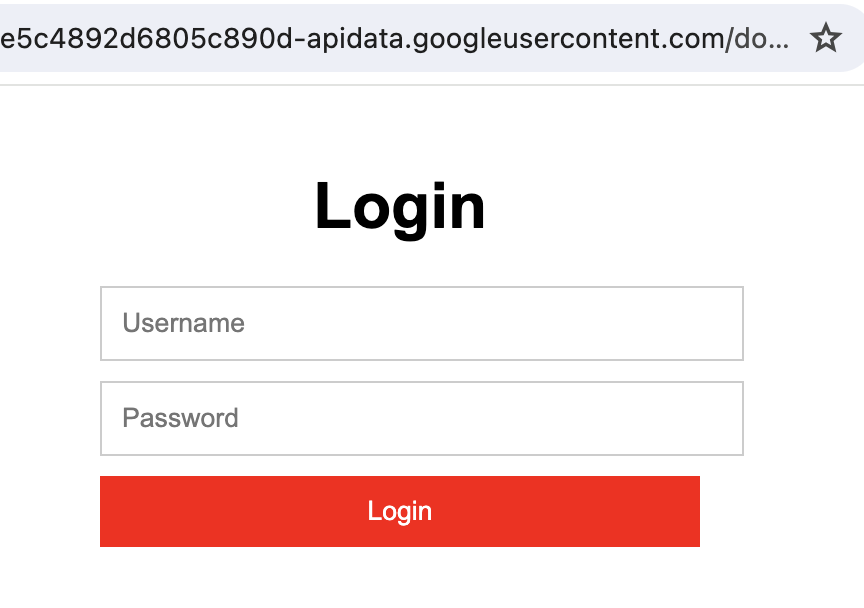2 at 3.50.46 PM.png](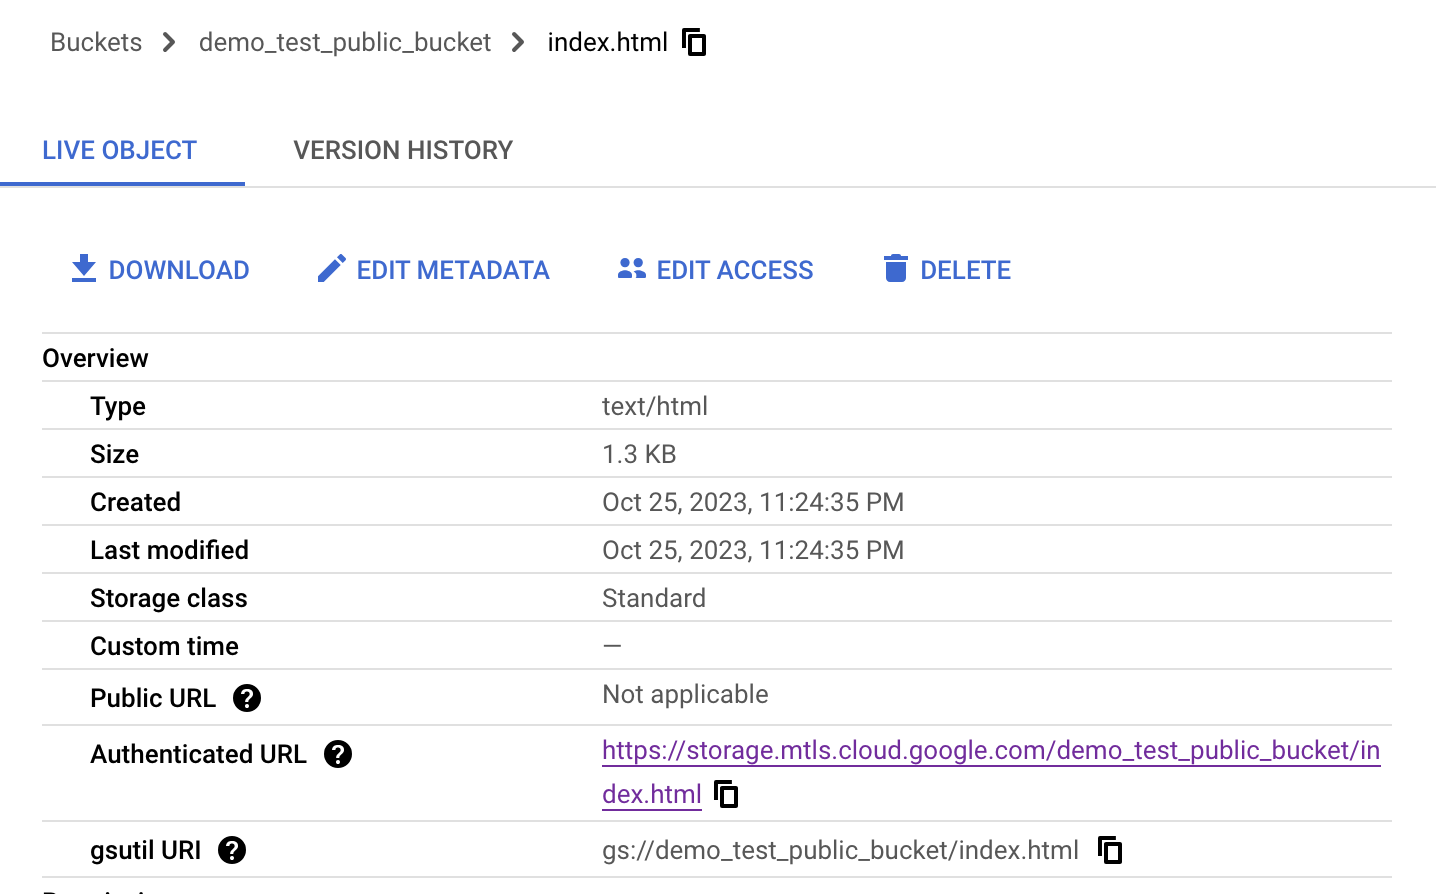)


## Step 4: Change Website Design (Login Button Color)

In addition to function generation, you can use code chat API to modify the code.

In this example, we asked the code chat API to modify index.html to make the button red. We reupload it to the GCS bucket after that, you should be able to see the live update right there.

In [ ]:
message = f"""Change the login button to red
"""
index_page = send_message(message)

In [ ]:
index_page=index_page.removeprefix(' ```html').removesuffix('```')
write_file("index.html", index_page)

upload_blob("demo_test_public_bucket","index.html","index.html")

File index.html uploaded to index.html.


Click the Authenticated URL of the index.html file in your GCS bucket to check out the live update
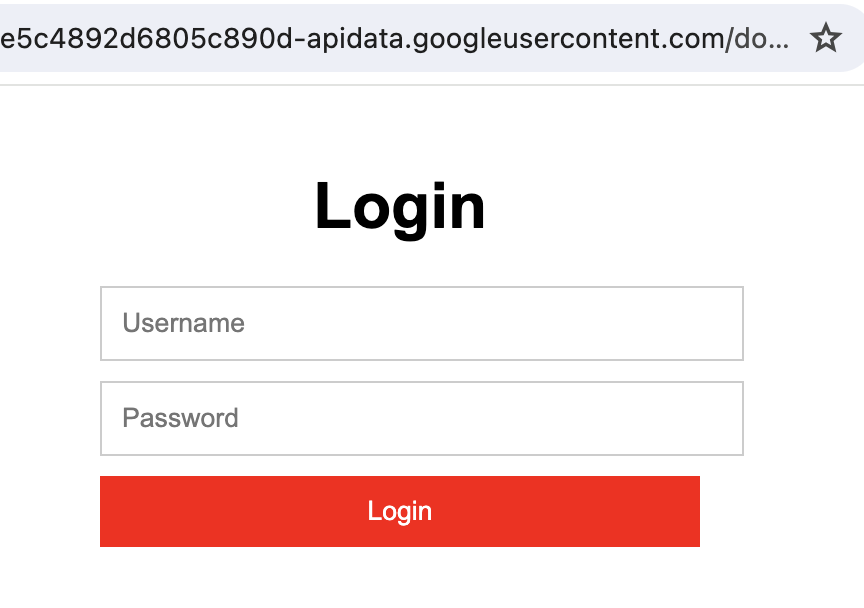




## Step 5: Add Javascript Code to Handle the Login Logic

In addition to the example above, you can also add code to the existing code base. Before you implement this example below, the login button is not functional.

Once you finish the example below, you should be able to type the username and password to see a popup window.

In [ ]:
message = f"""Add Javascript code to handle the click of the red login button.
If username is 'Lei' and password is '1234',
please show a popup window saying 'Success!',
otherwise please a popup window saying 'Login Failed!'
"""
index_page = send_message(message)

In [ ]:
index_page=index_page.removeprefix(' ```html').removesuffix('```')
write_file("index.html", index_page)

upload_blob("demo_test_public_bucket","index.html","index.html")

File index.html uploaded to index.html.


Click the Authenticated URL of the index.html file in your GCS bucket to check out the live update

## Step 6: Write Unit Test for Javascript Code

You can also write unit test for the code you generate by prompting the code chat API in the following way.

In [ ]:
message = f"""Write unit test for the Javascript code you just generated
"""
unit_test = send_message(message)
print(unit_test)

 ```javascript
import { login } from './login.js';

describe('Login function', () => {
  it('should return true if username is Lei and password is 1234', () => {
    const username = 'Lei';
    const password = '1234';

    const result = login(username, password);

    expect(result).toBe(true);
  });

  it('should return false if username is not Lei or password is not 1234', () => {
    const username = 'Not Lei';
    const password = 'Not 1234';

    const result = login(username, password);

    expect(result).toBe(false);
  });
});
```


## Step 7: Explain Generated HTML, CSS and Javascript Code

You can explain the code you generate by prompting the code chat API in the following way.

In [ ]:
message = f"""Explain the code line by line {index_page}
"""
explanation = send_message(message)
print(explanation)

 ```html
<!DOCTYPE html>
```

This line tells the browser that this is an HTML5 document.

```
<html>
```

This line starts the HTML document.

```
<head>
```

This line starts the head section of the document. The head section contains information about the document, such as the title and the author.

```
<title>Login Page</title>
```

This line sets the title of the document.

```
<style>
```

This line starts the style section of the document. The style section contains the CSS code that styles the document.

```
body {
  font-family: Arial, Helvetica, sans-serif;
  margin: 0;
}

.login-form {
  width: 300px;
  margin: 0 auto;
  padding: 20px;
}

.login-form h1 {
  text-align: center;
}

.login-form input {
  width: 100%;
  padding: 10px;
  margin-bottom: 10px;
  border: 1px solid #ccc;
}

.login-form button {
  width: 100%;
  padding: 10px;
  background-color: red;
  color: #fff;
  border: none;
  cursor: pointer;
}
```

This CSS code styles the document. It sets the font family, t

## Step 8: Refactor the Code

The last example in this notebook is code refactoring via code chat API. We want to separate this long index.html file to 3 different files, so it's modular and easier to maintain.

In [ ]:
message = f"""Split {index_page} into 3 files including HTML, CSS and Javascript files
"""
refactor_code = send_message(message,2048)
print(refactor_code)

 HTML file:

```html
<!DOCTYPE html>
<html>
<head>
  <title>Login Page</title>
  <link rel="stylesheet" href="style.css">
</head>
<body>
  <div class="login-form">
    <h1>Login</h1>
    <form action="/login" method="post">
      <input type="text" name="username" placeholder="Username">
      <input type="password" name="password" placeholder="Password">
      <button type="button" onclick="login()" style="background-color: red;">Login</button>
    </form>
  </div>

  <script src="script.js"></script>
</body>
</html>
```

CSS file:

```css
body {
  font-family: Arial, Helvetica, sans-serif;
  margin: 0;
}

.login-form {
  width: 300px;
  margin: 0 auto;
  padding: 20px;
}

.login-form h1 {
  text-align: center;
}

.login-form input {
  width: 100%;
  padding: 10px;
  margin-bottom: 10px;
  border: 1px solid #ccc;
}

.login-form button {
  width: 100%;
  padding: 10px;
  background-color: red;
  color: #fff;
  border: none;
  cursor: pointer;
}
```

JavaScript file:

```javascript
func